In [1]:
import os
import shutil
import random

for directory in ['data', 'data/train', 'data/train/couch', 'data/train/dining_chair',
                  'data/validation', 'data/validation/couch', 'data/validation/dining_chair']:
    if not os.path.exists(os.path.join(os.getcwd(), directory)):
        os.mkdir(os.path.join(os.getcwd(), directory))

## Base Model 1

In [2]:
# Shuffle 
couch_files = os.listdir('data/couch')
random.shuffle(couch_files)
chair_files = os.listdir('data/dining_chair')
random.shuffle(chair_files)

# Couch has 2016 files
couch_train_files = couch_files[:1500]
# Dining chair has 8141 files
dining_chair_train_files = chair_files[:1500]

couch_validation_files = couch_files[1500:]
dining_chair_validation_files = chair_files[1500:]

In [3]:
for img_file in dining_chair_train_files:
    shutil.move(os.path.join(os.getcwd(), 'data/dining_chair', img_file), os.path.join(os.getcwd(), 'data/train/dining_chair', img_file))
for img_file in couch_train_files:
    shutil.move(os.path.join(os.getcwd(), 'data/couch', img_file), os.path.join(os.getcwd(), 'data/train/couch', img_file))

for img_file in dining_chair_validation_files:
    shutil.move(os.path.join(os.getcwd(), 'data/dining_chair', img_file), os.path.join(os.getcwd(), 'data/validation/dining_chair', img_file))
for img_file in couch_validation_files:
    shutil.move(os.path.join(os.getcwd(), 'data/couch', img_file), os.path.join(os.getcwd(), 'data/validation/couch', img_file))

In [4]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Base Model 

In [50]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 3000
nb_validation_samples = 835 
epochs = 2
batch_size = 32

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', f1])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('weights3.h5')

Found 3000 images belonging to 2 classes.
Found 835 images belonging to 2 classes.
Epoch 1/2
93/93 [==============================] - 559s 6s/step - loss: 0.6345 - acc: 0.7191 - f1: 0.6903 - val_loss: 0.3041 - val_acc: 0.8678 - val_f1: 0.7453
Epoch 2/2
93/93 [==============================] - 517s 6s/step - loss: 0.3752 - acc: 0.8511 - f1: 0.8456 - val_loss: 0.2196 - val_acc: 0.9029 - val_f1: 0.7769


In [1]:
#model.load_weights('weights3.h5')

In [52]:
predictions = model.predict_generator(validation_generator)  ##try validation_generator.reset()

In [53]:
import numpy as np
preds = predictions.reshape(len(predictions),)
correct_ind = np.round(preds) == validation_generator.classes
incorrect_ind = [not i for i in correct_ind]
accuracy = np.sum(correct_ind) / float(len(preds)) * 100
print(accuracy)

90.2994011976


## Visulization

In [ ]:
from keras.layers import Convolution2D, MaxPooling2D, Activation
import matplotlib.pyplot as plt
import cv2 
%matplotlib inline
#couch1 = cv2.imread('data/train/couch/28881426.png')
couch1 = cv2.imread('data/dining_chair/34441227.png')

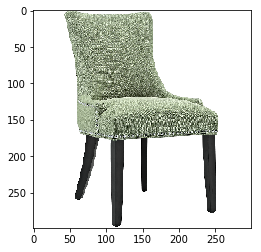

In [404]:
plt.imshow(couch1)

In [405]:
couch1.shape

(299, 299, 3)

In [406]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 297, 297, 32)      896       
_________________________________________________________________
activation_26 (Activation)   (None, 297, 297, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_27 (Activation)   (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 71, 71, 64)        18496     
__________

In [407]:
couch1.shape

(299, 299, 3)

## Convolution2D

In [408]:
test_model=Sequential()
test_model.add(Conv2D(1, (3, 3), input_shape=couch1.shape))
test_model.layers[0].set_weights(
     [model.layers[0].get_weights()[0][:,:,:,0].reshape((3,3,3,1)), 
      np.array([model.layers[0].get_weights()[1][0]])])
#test_model.layers[0].set_weights(
#    list(model.layers[0].get_weights()[:, 0]))

In [409]:
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 297, 297, 1)       28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [410]:
couch_batch=np.expand_dims(couch1, axis=0)

In [411]:
conv_couch=test_model.predict(couch_batch)

In [443]:
def visualize_couch(couch_batch):
    couch1=np.squeeze(couch_batch, axis=0)

    couch1=np.squeeze(couch1, axis=-1)
    #print couch1.shape
    plt.imshow(couch1)

(297, 297)


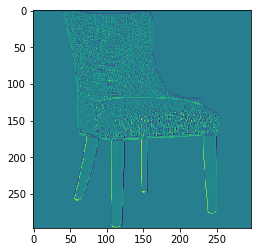

In [413]:
visualize_couch(conv_couch)

## +RELU

In [414]:
test_model.add(Activation('relu'))

In [415]:
conv_couch1=test_model.predict(couch_batch)

(297, 297)


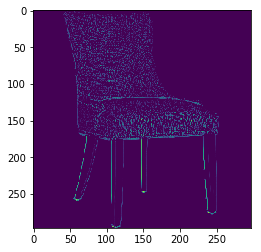

In [416]:
visualize_couch(conv_couch1)

## +MaxPooling2D

In [417]:
test_model.add(MaxPooling2D(pool_size=(2, 2)))

In [418]:
conv_couch2=test_model.predict(couch_batch)

(148, 148)


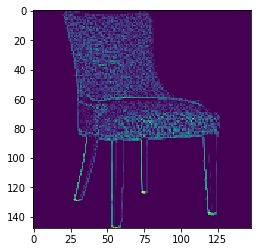

In [419]:
visualize_couch(conv_couch2)

In [420]:
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 297, 297, 1)       28        
_________________________________________________________________
activation_42 (Activation)   (None, 297, 297, 1)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 148, 148, 1)       0         
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [421]:
test_model.add(Conv2D(1, (3, 3), input_shape=(148, 148, 32)))
test_model.layers[3].set_weights(
     [model.layers[3].get_weights()[0][:,:,0,0].reshape(3,3,1,1), 
      np.array([model.layers[3].get_weights()[1][0]])])

In [422]:
conv_couch3=test_model.predict(couch_batch)

(146, 146)


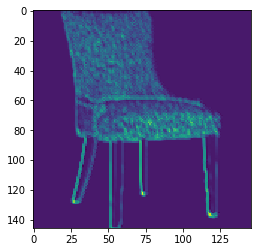

In [423]:
visualize_couch(conv_couch3)

(146, 146)


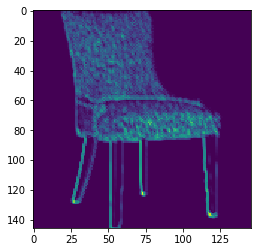

In [424]:
test_model.add(Activation('relu'))
conv_couch4=test_model.predict(couch_batch)
visualize_couch(conv_couch4)

(73, 73)


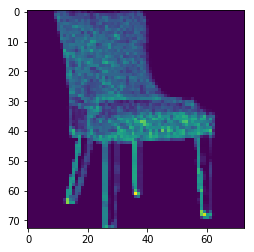

In [425]:
test_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_couch5=test_model.predict(couch_batch)
visualize_couch(conv_couch5)

In [426]:
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 297, 297, 1)       28        
_________________________________________________________________
activation_42 (Activation)   (None, 297, 297, 1)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 148, 148, 1)       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 146, 146, 1)       10        
_________________________________________________________________
activation_43 (Activation)   (None, 146, 146, 1)       0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 73, 73, 1)         0         
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [427]:
test_model.add(Conv2D(1, (3, 3), input_shape=(73, 73, 32)))
test_model.layers[6].set_weights(
     [model.layers[6].get_weights()[0][:,:,0,0].reshape(3,3,1,1), 
      np.array([model.layers[6].get_weights()[1][0]])])

(71, 71)


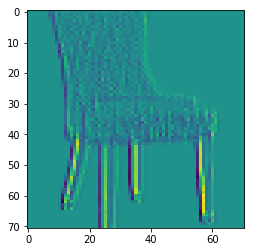

In [428]:
conv_couch6=test_model.predict(couch_batch)
visualize_couch(conv_couch6)

(71, 71)


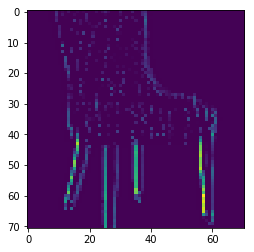

In [429]:
test_model.add(Activation('relu'))
conv_couch7=test_model.predict(couch_batch)
visualize_couch(conv_couch7)

(35, 35)


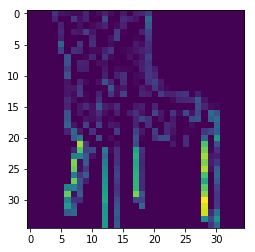

In [430]:
test_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_couch8=test_model.predict(couch_batch)
visualize_couch(conv_couch8)

In [20]:
f1_result = f1(K.variable(validation_generator.classes), K.variable(np.round(preds)))

In [21]:
K.eval(f1_result)

0.90999746